CS770 Machine Learning Project: Bag of Tricks for Efficient Text Classification

Sumbitted by Maddox Kafka H268R726


This file contains the implementation, training, and testing of the proposed comparison model followed by the testing of the model implemented by the original paper, using its official Python library.

If you are interested in seeing how the Reddit data was scraped or how the FastText corpora were formatted, see https://github.com/Maddox-K/CS770_project

In [1]:
import pandas as pd
import numpy as np
import time
import pickle
import fasttext
import csv
import json
import seaborn as sns

from scipy import stats

import matplotlib
import matplotlib.pyplot as plt

import statsmodels.api as sm

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

<h1>Proposed Model Architecture</h1>

<h3>Feature Embeddings and Scaling</h3>

In [13]:
"""
Step 1 of Model:
Function to train the n-gram embeddings on the text data
Takes in eight parameters: the dataset, the list with which to append recorded training times, and the train-test-validation split sets of the data
As a form of hyperparameter tuning, three n-gram ranges are tried, a small range of 1-2 characters, a set small amount of exactly 2 characters only,
and a wider range of 3-6 characters
Each dataset will choose the n-gram range that results in the most accurate classification

SVD compresses sparse vector spaces into 200-length vectors
Preliminary testing indicated diminishing returns on accuracy after this 200 point

Minumum number of occurrences required to be considered part of the corpus vocabulary is set to 10
This amount generalizes well to many datasets while acting as a preliminary form of feature selection

Random state of 42 is used for reproducible results
"""

def train_embeddings(dataset, times_list, X_train, X_test, X_tune, y_train, y_test, y_tune):
    for i in range(3):
        match i:
            case 0:
                ngram = (1,2)
            case 1:
                ngram = (2,2)
            case 2:
                ngram = (3,6)

        # record start time of data training model
        start_time = time.perf_counter()

        # tfidf vectorizer using character n-grams (with bounds), various n-gram ranges, and keep features in vocab that appear at least 10 times
        vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=ngram, min_df=10)
        X_train_vectors = vectorizer.fit_transform(X_train)
        X_test_vectors = vectorizer.transform(X_test)
        X_tune_vectors = vectorizer.transform(X_tune)
    
        # dimensionality reduction of sparce vectors from vectorization
        # convert sparse vectors into dense n-gram embedding vectors
        # somewhat of an imitation of fasttext's word embedding hidden layer
        svd = TruncatedSVD(n_components=200, random_state=42)
        X_train_dense = svd.fit_transform(X_train_vectors)
        X_test_dense = svd.transform(X_test_vectors)
        X_tune_dense = svd.transform(X_tune_vectors)

        # scale resulting data
        # normalization of input is done using sklearn's Standard Scaler, which uses Z-score normalization to make data follow more of a normal distribution
        # this is a requirement for effective use of the classifier functions
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_dense)
        X_test_scaled = scaler.transform(X_test_dense)
        X_tune_scaled = scaler.transform(X_tune_dense)

        # get total time taken to train and scale
        end_time = time.perf_counter()
        initial_elapsed_time = end_time - start_time
        times_list.append(initial_elapsed_time)

        print(f"Time Taken to Embed and Scale {ngram} ngram Features:")
        print(str(initial_elapsed_time) + " Seconds")

        # save embedding vectors so that they can be retrieved later without retraining if needed
        np.savez(f"{dataset}_data/{dataset}_embeddings{i}.npz", train=X_train_scaled, test=X_test_scaled, tune=X_tune_scaled, ytrain=y_train, ytest=y_test, ytune=y_tune)

<h3>Classifier Models</h3>

In [15]:
"""
Logistic Regression function
takes in train, test, validation splits of dataset and trains a series of LR models, each using a different regularization term
10 total hyperparameter values are tried
function uses the best found C hyperparameter value and trains the final model iteration using that parameter

SAGA solver is used as it converges much more quickly (and effectively) on larger datasets
"""

def train_lr(xtrain, ytrain, xtest, ytest, xtune, ytune):
    c_scores = []
    c_values = np.logspace(-3, 1, num=10) # try evenly-spaced values on the range [10^-3, 10^1]
    if ytrain.dtype == 'object':
        label = 'positive'
    else:
        label = 1
    
    for c in c_values: # try a model for each C value
        LR = LogisticRegression(C=c, solver='saga', max_iter=1000, random_state=42, n_jobs=-1)
        LR.fit(xtrain, ytrain)
        prediction = LR.predict(xtune)
        c_scores.append(f1_score(ytune, prediction, pos_label=label))
    arg = np.argmax(c_scores)
    optimal_c = c_values[arg]

    LR = LogisticRegression(C=optimal_c, solver='saga', max_iter=1000, random_state=42, n_jobs=-1) # train model using tuned C value
    LR.fit(xtrain, ytrain)
    prediction = LR.predict(xtest)

    # return the set of model predictions and the tuned hyperparameter value
    return prediction, optimal_c

In [17]:
"""
Support Vector Machine Function
Takes in same parameters as logistic regression function

Implements hyperparameter tuning by trying different C (inverse regularization) values
Tries values from the set {.001, .01, .1, 1}

LinearSVC function is used as it tends to perform better on larger datasets
loss is set to hinge, as this is the typical loss function that SVM uses

convergence tolerance is set to be higher than normal due to convergence issues on the larger dataset
Number of iterations generally works at many values, but value is set to 14000 to ensure convergence no matter what dataset is input into the classifier
"""

def train_svm(xtrain, ytrain, xtest, ytest, xtune, ytune):
    c_values = [.001, .01, .1, 1] # C values to try
    c_scores = []
    if ytrain.dtype == 'object':
        label = 'positive'
    else:
        label = 1

    for c in c_values:
        svc = LinearSVC(loss='hinge', C=c, max_iter=14000, tol=1e-1, random_state=42) # train series of models using different C values
        svc.fit(xtrain, ytrain)
        prediction = svc.predict(xtune)
        c_scores.append(f1_score(ytune, prediction, pos_label=label))
    arg = np.argmax(c_scores)
    optimal_c = c_values[arg]

    svc = LinearSVC(loss='hinge', C=optimal_c, max_iter=14000, tol=1e-2, random_state=42)
    svc.fit(xtrain, ytrain)
    prediction = svc.predict(xtest)

    return prediction, optimal_c

In [19]:
"""
Random Forest Classifier Function

implements some level of hyperparameter tuning by testing different splitting criteria for the nodes of the trees
Number of tress in the forest is left as the default value to due preliminary tests indicating drastically diminishing returns on the number of trees

Generally takes longer to train than the classifiers above due to the complexity of the model
"""

def train_forest(xtrain, ytrain, xtest, ytest, xtune, ytune):
    criteria = ['gini', 'entropy', 'log_loss'] # splitting criteria to try
    crit_scores = []
    if ytrain.dtype == 'object':
        label = 'positive'
    else:
        label = 1

    for criterion in criteria:
        forest_clf = RandomForestClassifier(criterion=criterion, random_state=42)
        forest_clf.fit(xtrain, ytrain)
        prediction = forest_clf.predict(xtune)
        crit_scores.append(f1_score(ytune, prediction, pos_label=label))
    arg = np.argmax(crit_scores)
    optimal_crit = criteria[arg]

    forest = RandomForestClassifier(criterion=optimal_crit, random_state=42)
    forest.fit(xtrain, ytrain)
    prediction = forest.predict(xtest)

    return prediction, optimal_crit

<h1>IMDB Classification</h1>

In [56]:
# initialize lists of training times for IMDB set
imdb_embedding_times = []
imdb_classifier_times = []

# initialize lists of model evaluation metrics for IMDB set
imdb_accs = []
imdb_scores = []
imdb_precs = []
imdb_recs = []

IMDB Dataset Shape:
(50000, 2) 

Number of Positive Reviews: 25000
Number of Negative Reviews: 25000


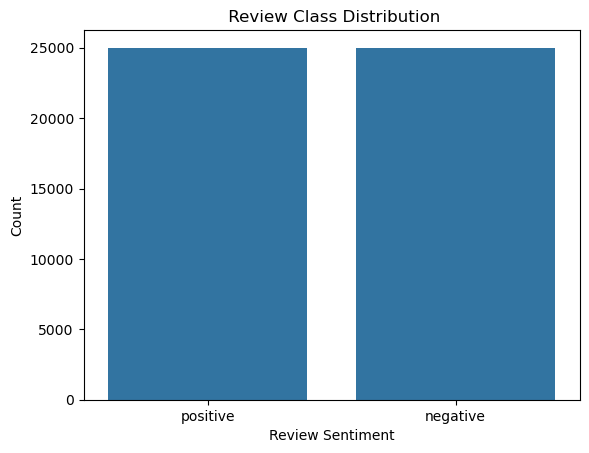

In [115]:
df = pd.read_csv("C:/Users/atobo/CS770_data/project_data/imdb_data/IMDB Dataset.csv")

# clean review text data by removing html break tags and removing unicode characters
df['review'] = df['review'].str.replace("<br /><br />", " ").str.replace('\u200b', '').str.strip()

# X contains text contents of reviews, y contains labeled reivew sentiment
X = df['review']
y = df['sentiment']

# split the data into training, testing and validation data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_tune, y_test, y_tune = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)


# EDA: get information such as the number of samples in the set as well as the number of samples from each class
print("IMDB Dataset Shape:")
print(df.shape, "\n")
print("Number of Positive Reviews:", df[df['sentiment'] == 'positive'].shape[0])
print("Number of Negative Reviews:", df[df['sentiment'] == 'negative'].shape[0])

sns.countplot(x='sentiment', data=df)
plt.title(' Review Class Distribution')
plt.xlabel('Review Sentiment')
plt.ylabel('Count')
plt.show()

In [145]:
# To further explore and get a feel for the data, get a sample from each of the classes
print("Example of a Positive Review:")
print(df[df['sentiment'] == 'positive'].sample(1)['review'].values[0])

print("\nExample of a Negative Review:")
print(df[df['sentiment'] == 'negative'].sample(1)['review'].values[0])

Example of a Positive Review:
Wes Craven has been created a most successful killer-thriller movies of all time. After watching he's movies, you will find your new fears. People don't know, which Wes Craven's thriller movie is the best, because they all different. In this movie, Lisa is terrorize by fellow-traveler. He coercible her to kill and if she don't do this, Jack will kill her father. Lisa is in the huge mess, because whatever she choose, she will kill. Acting was unreal. Rachel McAdams and Cillian Murphy acted unbelievable good. The emotions was in right choose. Idea and script of this movie is great too... Sometimes it reminds a "Scream", but he definitely better, than both "Screams" sequels together. And what can I say - this is the best killer-thriller movie in 21's century yet...

Example of a Negative Review:
The video quality is awful. The sound quality is pathetic. The acting is horrific. The dialog is painful. The lighting is dismal. The editing is laughable. I could go

In [19]:
# call embedding training function on IMDB data
train_embeddings('imdb', imdb_embedding_times, X_train, X_test, X_tune, y_train, y_test, y_tune)

Time Taken to Embed and Scale (1, 2) ngram Features:
86.43052510000416 Seconds
Time Taken to Embed and Scale (2, 2) ngram Features:
54.62497939998866 Seconds
Time Taken to Embed and Scale (3, 6) ngram Features:
406.8610189000028 Seconds


In [25]:
# save embedding times using Python Pickle
with open('imdb_data/imdb_embedding_times.pkl', 'wb') as f:
    pickle.dump(imdb_embedding_times, f)
f.close()

In [58]:
"""
Determine best n-gram value for IMDB dataset based on performances of Logistic Regression models

Train logistic regression model for IMDB dataset and save model
"""

temp_predictions = []
temp_params = []
temp_scores = []
temp_times = []
ngram_values = [(1,2), (2,2), (3,6)]

for i in range(3):
    vectors = np.load(f"imdb_data/imdb_embeddings{i}.npz", allow_pickle=True)
    start_time = time.perf_counter()
    prediction, c_param = train_lr(vectors["train"], vectors["ytrain"], vectors["test"], vectors["ytest"], vectors["tune"], vectors["ytune"])
    end_time = time.perf_counter()
    temp_predictions.append(prediction)
    temp_params.append(c_param)
    total_time = end_time - start_time
    temp_times.append(total_time)
    f_one = f1_score(vectors["ytest"], prediction, pos_label='positive')
    temp_scores.append(f_one)

best_imdb_lr = temp_predictions[np.argmax(temp_scores)]
best_c = temp_params[np.argmax(temp_scores)]
best_ngram = ngram_values[np.argmax(temp_scores)]
time_taken = temp_times[np.argmax(temp_scores)]

ytest = vectors["ytest"]
acc = accuracy_score(ytest, best_imdb_lr)
f1 = f1_score(ytest, best_imdb_lr, pos_label='positive')
prec = precision_score(ytest, best_imdb_lr, pos_label='positive')
rec = recall_score(ytest, best_imdb_lr, pos_label='positive')
imdb_classifier_times.append(time_taken)
imdb_accs.append(acc)
imdb_scores.append(f1)
imdb_precs.append(prec)
imdb_recs.append(rec)

imdb_lr = {'predictions': best_imdb_lr, 'c_value': best_c, 'best_ngram': best_ngram}
with open('imdb_data/imdb_lr.pkl', 'wb') as f:
    pickle.dump(imdb_lr, f)
f.close()

In [60]:
print(f"Best n-gram Range to Use for IMDB Dataset: {best_ngram}\n")
print(f"Tuned Logstic Regression C Value: {best_c}\n")
print(confusion_matrix(ytest, best_imdb_lr), "\n")
print(classification_report(ytest, best_imdb_lr))

Best n-gram Range to Use for IMDB Dataset: (3, 6)

Tuned Logstic Regression C Value: 0.007742636826811269

[[4314  688]
 [ 638 4365]] 

              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      5002
    positive       0.86      0.87      0.87      5003

    accuracy                           0.87     10005
   macro avg       0.87      0.87      0.87     10005
weighted avg       0.87      0.87      0.87     10005



In [72]:
"""
Train SVM classification model on IMDB dataset
Assume that best n-gram range determined above applies for all classifiers (including this one)
"""

vectors = np.load(f"imdb_data/imdb_embeddings2.npz", allow_pickle=True) # use embeddidngs based on "best" n-gram range
start_time = time.perf_counter()
prediction, c_param = train_svm(vectors["train"], vectors["ytrain"], vectors["test"], vectors["ytest"], vectors["tune"], vectors["ytune"])
end_time = time.perf_counter()
total_time = end_time - start_time

ytest = vectors["ytest"]
acc = accuracy_score(ytest, prediction)
f1 = f1_score(ytest, prediction, pos_label='positive')
prec = precision_score(ytest, prediction, pos_label='positive')
rec = recall_score(ytest, prediction, pos_label='positive')
imdb_classifier_times.append(total_time)
imdb_accs.append(acc)
imdb_scores.append(f1)
imdb_precs.append(prec)
imdb_recs.append(rec)

imdb_svm = {'predictions': prediction, 'c_value': c_param}
with open('imdb_data/imdb_svm.pkl', 'wb') as f:
    pickle.dump(imdb_svm, f)
f.close()

In [74]:
print(f"Tuned SVM C Value: {c_param}\n")
print(confusion_matrix(ytest, prediction), "\n")
print(classification_report(ytest, prediction))

Tuned SVM C Value: 0.001

[[4282  720]
 [ 622 4381]] 

              precision    recall  f1-score   support

    negative       0.87      0.86      0.86      5002
    positive       0.86      0.88      0.87      5003

    accuracy                           0.87     10005
   macro avg       0.87      0.87      0.87     10005
weighted avg       0.87      0.87      0.87     10005



In [84]:
# train random forest classifier on IMDB dataset

vectors = np.load(f"imdb_data/imdb_embeddings2.npz", allow_pickle=True)
start_time = time.perf_counter()
prediction, crit = train_forest(vectors["train"], vectors["ytrain"], vectors["test"], vectors["ytest"], vectors["tune"], vectors["ytune"])
end_time = time.perf_counter()
total_time = end_time - start_time

ytest = vectors["ytest"]
acc = accuracy_score(ytest, prediction)
f1 = f1_score(ytest, prediction, pos_label='positive')
prec = precision_score(ytest, prediction, pos_label='positive')
rec = recall_score(ytest, prediction, pos_label='positive')
imdb_classifier_times.append(total_time)
imdb_accs.append(acc)
imdb_scores.append(f1)
imdb_precs.append(prec)
imdb_recs.append(rec)

imdb_forest = {'predictions': prediction, 'criterion': crit}
with open('imdb_data/imdb_forest.pkl', 'wb') as f:
    pickle.dump(imdb_forest, f)
f.close()

In [86]:
print(f"Tuned Random Forest Splitting Criterion: {crit}\n")
print(confusion_matrix(ytest, prediction), "\n")
print(classification_report(ytest, prediction))

Tuned Random Forest Splitting Criterion: gini

[[4049  953]
 [ 970 4033]] 

              precision    recall  f1-score   support

    negative       0.81      0.81      0.81      5002
    positive       0.81      0.81      0.81      5003

    accuracy                           0.81     10005
   macro avg       0.81      0.81      0.81     10005
weighted avg       0.81      0.81      0.81     10005



In [88]:
# save evaluation metrics for each IMDB classifier as a dictionary using Python Pickle

imdb_classifier_stats = {'times': imdb_classifier_times, 'accuracies': imdb_accs, 'scores': imdb_scores, 'precisions': imdb_precs, 'recalls': imdb_recs}

with open('imdb_data/imdb_classifier_stats.pkl', 'wb') as f:
    pickle.dump(imdb_classifier_stats, f)
f.close()

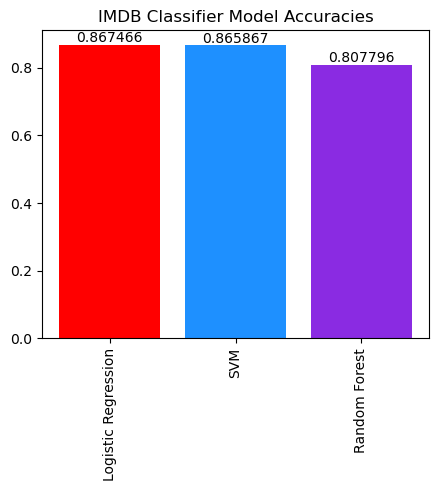

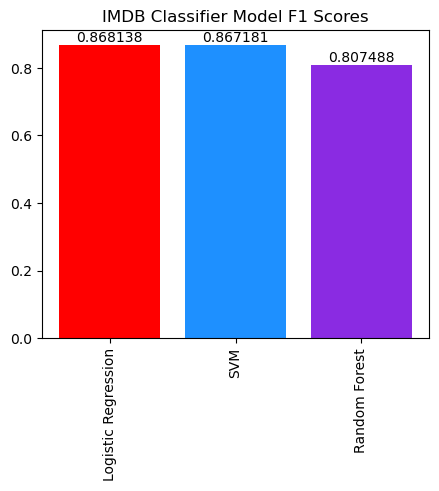


Time Taken to Train Model with Highest F1 Score:
20.21338690002449

Total Time Including Embeddings:
427.0744058000273


In [31]:
"""
Model Comparisons and evaluation
Load model stats from filesystem and compare using bar charts

The main metrics we care about are accuracy and F1 score, so those are charted below

Finally, determine which classifier works best for the dataset (based on F1 score) and get the total time taken to train the model
"""

with open('imdb_data/imdb_classifier_stats.pkl', 'rb') as f:
    imdb_classifier_stats = pickle.load(f)
f.close()
with open('imdb_data/imdb_embedding_times.pkl', 'rb') as f:
    imdb_embedding_times = pickle.load(f)
f.close()

imdb_classifier_times = imdb_classifier_stats['times']

imdb_accs = imdb_classifier_stats['accuracies']
imdb_scores = imdb_classifier_stats['scores']
imdb_precs = imdb_classifier_stats['precisions']
imdb_recs = imdb_classifier_stats['recalls']

models = ['Logistic Regression', 'SVM', 'Random Forest']
colors = ['r', 'dodgerblue', 'blueviolet']

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, imdb_accs, color=colors)
ax.bar_label(bars)
plt.title("IMDB Classifier Model Accuracies")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, imdb_scores, color=colors)
ax.bar_label(bars)
plt.title("IMDB Classifier Model F1 Scores")
plt.xticks(rotation=90)
plt.show()

print("\nTime Taken to Train Model with Highest F1 Score:")
print(str(imdb_classifier_times[np.argmax(imdb_scores)]))
print("\nTotal Time Including Embeddings:")
print(str(imdb_classifier_times[np.argmax(imdb_scores)] + imdb_embedding_times[2]))

<h1>Reddit "AITA" Classification</h1>

In [7]:
# initialize lists of Reddit training times
reddit_embedding_times = []
reddit_classifier_times = []

# initialize lists of Reddit model evaluation metrics
reddit_accs = []
reddit_scores = []
reddit_precs = []
reddit_recs = []

Reddit Dataset Shape:
(2621, 2) 

Number of NTA Verdicts: 1412
Number of YTA Verdicts: 1209


C:\Users\atobo\AppData\Local\Temp\ipykernel_15432\3333531853.py:19: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['verdict'] = data['verdict'].replace({'Asshole' : 1, 'Asshole POO Mode' : 1, 'Not the A-hole' : 0, 'Not the A-hole POO Mode' : 0})


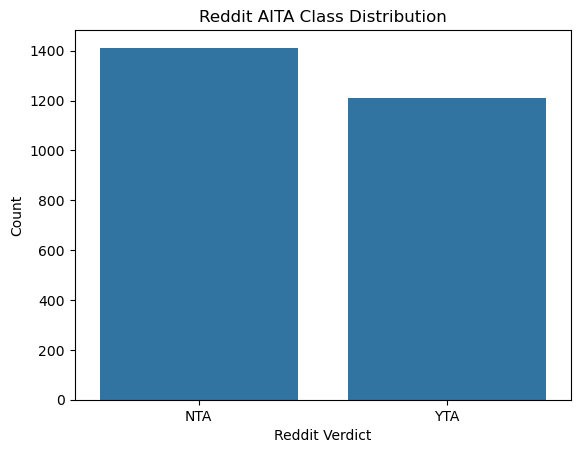

Reddit Dataset Shape After Undersampling:
(2418, 2) 

Number of NTA Verdicts: 1209
Number of YTA Verdicts: 1209


In [147]:
"""
Load scraped Reddit data from JSON file and explore dataset
Raw data JSON contains many features, but for the purposes of text classificatoin evaluation we only care about the actual textual content of the posts
and their respective labels (YTA or NTA)
"""

# load json file containing reddit post data
with open('reddit_data/aita_data.json') as f:
    raw_data = json.load(f)

# get posts as a dataframe
data = pd.json_normalize(raw_data['posts']).drop_duplicates()

data = data[['selftext', 'link_flair_text']]
data = data.rename(columns={'selftext': 'content', 'link_flair_text': 'verdict'})
data['content'] = data['content'].apply(lambda x: x.strip()) # clean leading and trailing spaces by stripping column strings

# convert verdicts into either 0 (nta), or 1 (yta)
data['verdict'] = data['verdict'].replace({'Asshole' : 1, 'Asshole POO Mode' : 1, 'Not the A-hole' : 0, 'Not the A-hole POO Mode' : 0})

print("Reddit Dataset Shape:")
print(data.shape, "\n")
print("Number of NTA Verdicts:", data[data['verdict'] == 0].shape[0])
print("Number of YTA Verdicts:", data[data['verdict'] == 1].shape[0])

ax = sns.countplot(x='verdict', data=data)
ax.set_xticks([0,1])
ax.set_xticklabels(['NTA', 'YTA'])
plt.title('Reddit AITA Class Distribution')
plt.xlabel('Reddit Verdict')
plt.ylabel('Count')
plt.show()

yta = data.drop(data[data['verdict'] == 0].index.values)
nta = data.drop(data[data['verdict'] == 1].index.values)
nta2 = nta.sample(1209, random_state=42)

rejoined = []
rejoined.append(yta)
rejoined.append(nta2)

data = pd.concat(rejoined)
data = data.reset_index(drop=True)

print("Reddit Dataset Shape After Undersampling:")
print(data.shape, "\n")
print("Number of NTA Verdicts:", data[data['verdict'] == 0].shape[0])
print("Number of YTA Verdicts:", data[data['verdict'] == 1].shape[0])

X = data['content']
y = data['verdict']

# split the data into training, testing and validation data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_test, X_tune, y_test, y_tune = train_test_split(X_temp, y_temp, test_size=0.333, random_state=42, stratify=y_temp)

In [167]:
# To further explore and get a feel for the data, get a sample from each of the classes
print("Example of a Person Who Is Deemed \"Not the Asshole\":")
print(data[data['verdict'] == 0].sample(1)['content'].values[0])

print("\nExample of a Person Who Is Deemed \"the Asshole\":")
print(data[data['verdict'] == 1].sample(1)['content'].values[0])

Example of a Person Who Is Deemed "Not the Asshole":
I'm 20 years old, I moved out and cut contact with all my family other then my dad and my two brothers who had moved out years before this all, Now my aunt, who had stole money from me and my dad is asking me to give her a $2000 loan, I said no. And now my dad is getting a bunch of hate from all of my family about how I'm such an evil person for not giving my aunt money that I didn't know what she was going to use it for.. here's all that happened and why i cut contact and refuse to give her the money:  I had a house fire when I was 12, i lost my mother and brother in it,, the house that burnt down my parents didnt own that house, my aunt bought it, my parents paid rent plus all the bills, my aunt didnt get house insurance (WE THOUGHT SHE DID) so we got no money nor the Decision to keep the house up, During this time my dad was in surgery, so he was healing at the hospital  I went to go live with The aunt who had bought the house for

In [21]:
train_embeddings('reddit', reddit_embedding_times, X_train, X_test, X_tune, y_train, y_test, y_tune)

Time Taken to Embed and Scale (1, 2) ngram Features:
7.5766593999996985 Seconds
Time Taken to Embed and Scale (2, 2) ngram Features:
5.170548600000075 Seconds
Time Taken to Embed and Scale (3, 6) ngram Features:
22.159830800000236 Seconds


In [35]:
# save Reddit dataset feature embedding times
with open('reddit_data/reddit_embedding_times.pkl', 'wb') as f:
    pickle.dump(reddit_embedding_times, f)
f.close()

In [23]:
"""
Train Logistic Regression classifier on Reddit dataset
Train a LR classifier for each potential n-gram range, choosing the best based on F1 Score
"""

temp_predictions = []
temp_params = []
temp_scores = []
temp_times = []
ngram_values = [(1,2), (2,2), (3,6)]

for i in range(3):
    vectors = np.load(f"reddit_data/reddit_embeddings{i}.npz", allow_pickle=True)
    start_time = time.perf_counter()
    prediction, c_param = train_lr(vectors["train"], vectors["ytrain"], vectors["test"], vectors["ytest"], vectors["tune"], vectors["ytune"])
    end_time = time.perf_counter()
    temp_predictions.append(prediction)
    temp_params.append(c_param)
    total_time = end_time - start_time
    temp_times.append(total_time)
    f_one = f1_score(vectors["ytest"], prediction)
    temp_scores.append(f_one)

best_reddit_lr = temp_predictions[np.argmax(temp_scores)]
best_c = temp_params[np.argmax(temp_scores)]
best_ngram = ngram_values[np.argmax(temp_scores)]
time_taken = temp_times[np.argmax(temp_scores)]

ytest = vectors["ytest"]
acc = accuracy_score(ytest, best_reddit_lr)
f1 = f1_score(ytest, best_reddit_lr)
prec = precision_score(ytest, best_reddit_lr)
rec = recall_score(ytest, best_reddit_lr)
reddit_classifier_times.append(time_taken)
reddit_accs.append(acc)
reddit_scores.append(f1)
reddit_precs.append(prec)
reddit_recs.append(rec)

reddit_lr = {'predictions': best_reddit_lr, 'c_value': best_c, 'best_ngram': best_ngram}
with open('reddit_data/reddit_lr.pkl', 'wb') as f:
    pickle.dump(reddit_lr, f)
f.close()

In [25]:
print(f"Best n-gram Range to Use for Reddit Dataset: {best_ngram}\n")
print(f"Tuned Logstic Regression C Value: {best_c}\n")
print(confusion_matrix(ytest, best_reddit_lr), "\n")
print(classification_report(ytest, best_reddit_lr))

Best n-gram Range to Use for Reddit Dataset: (3, 6)

Tuned Logstic Regression C Value: 0.0027825594022071257

[[158  84]
 [ 82 160]] 

              precision    recall  f1-score   support

           0       0.66      0.65      0.66       242
           1       0.66      0.66      0.66       242

    accuracy                           0.66       484
   macro avg       0.66      0.66      0.66       484
weighted avg       0.66      0.66      0.66       484



In [27]:
vectors = np.load(f"reddit_data/reddit_embeddings2.npz", allow_pickle=True)
start_time = time.perf_counter()
prediction, c_param = train_svm(vectors["train"], vectors["ytrain"], vectors["test"], vectors["ytest"], vectors["tune"], vectors["ytune"])
end_time = time.perf_counter()
total_time = end_time - start_time

ytest = vectors["ytest"]
acc = accuracy_score(ytest, prediction)
f1 = f1_score(ytest, prediction)
prec = precision_score(ytest, prediction)
rec = recall_score(ytest, prediction)
reddit_classifier_times.append(total_time)
reddit_accs.append(acc)
reddit_scores.append(f1)
reddit_precs.append(prec)
reddit_recs.append(rec)

reddit_svm = {'predictions': prediction, 'c_value': c_param}
with open('reddit_data/reddit_svm.pkl', 'wb') as f:
    pickle.dump(reddit_svm, f)
f.close()

In [29]:
print(f"Tuned SVM C Value: {c_param}\n")
print(confusion_matrix(ytest, prediction), "\n")
print(classification_report(ytest, prediction))

Tuned SVM C Value: 1

[[153  89]
 [ 84 158]] 

              precision    recall  f1-score   support

           0       0.65      0.63      0.64       242
           1       0.64      0.65      0.65       242

    accuracy                           0.64       484
   macro avg       0.64      0.64      0.64       484
weighted avg       0.64      0.64      0.64       484



In [31]:
vectors = np.load(f"reddit_data/reddit_embeddings2.npz", allow_pickle=True)
start_time = time.perf_counter()
prediction, crit = train_forest(vectors["train"], vectors["ytrain"], vectors["test"], vectors["ytest"], vectors["tune"], vectors["ytune"])
end_time = time.perf_counter()
total_time = end_time - start_time

ytest = vectors["ytest"]
acc = accuracy_score(ytest, prediction)
f1 = f1_score(ytest, prediction)
prec = precision_score(ytest, prediction)
rec = recall_score(ytest, prediction)
reddit_classifier_times.append(total_time)
reddit_accs.append(acc)
reddit_scores.append(f1)
reddit_precs.append(prec)
reddit_recs.append(rec)

reddit_forest = {'predictions': prediction, 'criterion': crit}
with open('reddit_data/reddit_forest.pkl', 'wb') as f:
    pickle.dump(reddit_forest, f)
f.close()

In [33]:
print(f"Tuned Random Forest Splitting Criterion: {crit}\n")
print(confusion_matrix(ytest, prediction), "\n")
print(classification_report(ytest, prediction))

Tuned Random Forest Splitting Criterion: entropy

[[228  14]
 [117 125]] 

              precision    recall  f1-score   support

           0       0.66      0.94      0.78       242
           1       0.90      0.52      0.66       242

    accuracy                           0.73       484
   macro avg       0.78      0.73      0.72       484
weighted avg       0.78      0.73      0.72       484



In [37]:
# save classifier metrics as a dictionary

reddit_classifier_stats = {'times': reddit_classifier_times, 'accuracies': reddit_accs, 'scores': reddit_scores, 'precisions': reddit_precs, 'recalls': reddit_recs}

with open('reddit_data/reddit_classifier_stats.pkl', 'wb') as f:
    pickle.dump(reddit_classifier_stats, f)
f.close()

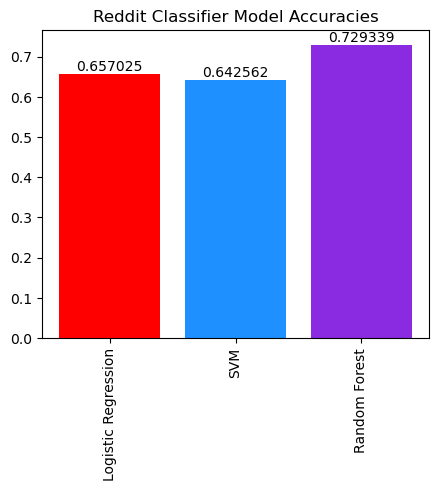

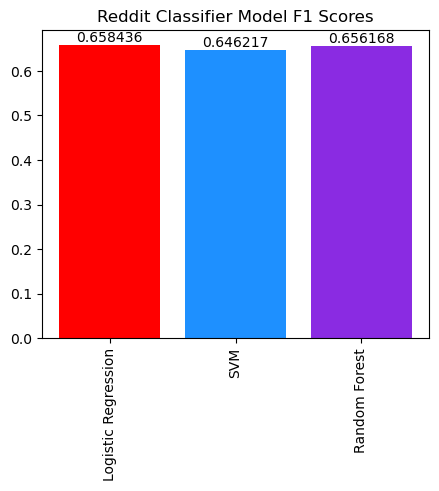


Time Taken to Train Model with Highest F1 Score:
1.6744219000001976

Total Time Including Embeddings:
23.834252700000434


In [39]:
with open('reddit_data/reddit_classifier_stats.pkl', 'rb') as f:
    reddit_classifier_stats = pickle.load(f)
f.close()
with open('reddit_data/reddit_embedding_times.pkl', 'rb') as f:
    reddit_embedding_times = pickle.load(f)
f.close()

reddit_classifier_times = reddit_classifier_stats['times']

reddit_accs = reddit_classifier_stats['accuracies']
reddit_scores = reddit_classifier_stats['scores']
reddit_precs = reddit_classifier_stats['precisions']
reddit_recs = reddit_classifier_stats['recalls']

models = ['Logistic Regression', 'SVM', 'Random Forest']
colors = ['r', 'dodgerblue', 'blueviolet']

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, reddit_accs, color=colors)
ax.bar_label(bars)
plt.title("Reddit Classifier Model Accuracies")
plt.xticks(rotation=90)
plt.show()

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, reddit_scores, color=colors)
ax.bar_label(bars)
plt.title("Reddit Classifier Model F1 Scores")
plt.xticks(rotation=90)
plt.show()

print("\nTime Taken to Train Model with Highest F1 Score:")
print(str(reddit_classifier_times[np.argmax(reddit_scores)]))
print("\nTotal Time Including Embeddings:")
print(str(reddit_classifier_times[np.argmax(reddit_scores)] + reddit_embedding_times[2]))

<h1>FastText Library Model Evaluation and Comparison</h1>

<h3>IMDB FastText Model</h3>

In [45]:
imdb_classifier_times = []

# initialize lists of model evaluation metrics for IMDB set
imdb_accs = []
imdb_scores = []
imdb_precs = []
imdb_recs = []

In [43]:
imdb_path = "C:/Users/atobo/CS770_data/project_data/imdb_data"

In [48]:
# record start time of training and predicting model
start_time = time.perf_counter()

# train fasttext model with no validation
imdb_model = fasttext.train_supervised(imdb_path + '/fasttext_train.txt')

# save total time taken to list of times
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Time Taken to Train IMDB Model")
print(elapsed_time)
imdb_classifier_times.append(elapsed_time)

imdb_model.save_model(imdb_path + "/fasttext_imdb_model.bin") # save model so it can be referenced later

Time Taken to Train IMDB Model
6.865764599999238


In [50]:
# train fasttext model with hyperparameter tuning on 10% validation set
imdb_tuned_model = fasttext.train_supervised(imdb_path + '/fasttext_train.txt', autotuneValidationFile=imdb_path + "/fasttext_tune.valid")

# save total time taken to list of times
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Time Taken to Train and Tune IMDB Model:")
print(elapsed_time)
imdb_classifier_times.append(elapsed_time)

imdb_tuned_model.save_model(imdb_path + "/fasttext_imdb_tuned_model.bin") # save model so it can be referenced later

Time Taken to Train and Tune IMDB Model:
337.99493059999986


In [52]:
# save training times using Python Pickle
with open('imdb_data/fasttext_imdb_training_times.pkl', 'wb') as f:
    pickle.dump(imdb_classifier_times, f)
f.close()

In [66]:
# loop through each of the model's predictions in order to get confusion matrix and classification report
true_labels = []
texts = []
with open(imdb_path + "/fasttext_test.txt", "r", encoding="utf-8") as f:
    for line in f:
        label, text = line.split(" ", 1) # split at space after __label__sentiment
        true_labels.append(label.strip())
        texts.append(text.strip())


imdb_model = fasttext.load_model(imdb_path + "/fasttext_imdb_model.bin") # load the previously created model
result = imdb_model.test(imdb_path + "/fasttext_test.txt") # use built-in test function to get precision, recall
print("Model F1 Score:")
fone = (2 * result[1] * result[2]) / (result[1] + result[2])
print(fone) # calculate F1 score from built-in test

predicted_labels = [imdb_model.predict(text)[0][0] for text in texts] # predict each entry in the data
acc = accuracy_score(true_labels, predicted_labels)
print("Model Accuracy:", acc)
imdb_accs.append(acc)
imdb_scores.append(fone)
prec = precision_score(true_labels, predicted_labels, pos_label="__label__positive")
imdb_precs.append(prec)
rec = recall_score(true_labels, predicted_labels, pos_label="__label__positive")
imdb_recs.append(rec)

# print confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__positive", "__label__negative"])
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["positive", "negative"]))


imdb_tuned_model = fasttext.load_model(imdb_path + "/fasttext_imdb_tuned_model.bin")
result = imdb_tuned_model.test(imdb_path + "/fasttext_test.txt")
print("\nTuned Model F1 Score:")
fone = (2 * result[1] * result[2]) / (result[1] + result[2])
print(fone) # calculate F1 score from built-in test

predicted_labels = [imdb_tuned_model.predict(text)[0][0] for text in texts] # predict each entry in the data
acc = accuracy_score(true_labels, predicted_labels)
print("Model Accuracy:", acc)
imdb_accs.append(acc)
imdb_scores.append(fone)
prec = precision_score(true_labels, predicted_labels, pos_label="__label__positive")
imdb_precs.append(prec)
rec = recall_score(true_labels, predicted_labels, pos_label="__label__positive")
imdb_recs.append(rec)

# print confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__positive", "__label__negative"])
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["positive", "negative"]))

Model F1 Score:
0.8764617691154423
Model Accuracy: 0.8764617691154423

Confusion Matrix:
[[4422  581]
 [ 655 4347]]

Classification Report:
              precision    recall  f1-score   support

    positive       0.88      0.87      0.88      5002
    negative       0.87      0.88      0.88      5003

    accuracy                           0.88     10005
   macro avg       0.88      0.88      0.88     10005
weighted avg       0.88      0.88      0.88     10005


Tuned Model F1 Score:
0.9004497751124437
Model Accuracy: 0.9004497751124437

Confusion Matrix:
[[4537  466]
 [ 530 4472]]

Classification Report:
              precision    recall  f1-score   support

    positive       0.91      0.89      0.90      5002
    negative       0.90      0.91      0.90      5003

    accuracy                           0.90     10005
   macro avg       0.90      0.90      0.90     10005
weighted avg       0.90      0.90      0.90     10005



In [68]:
# save evaluation metrics for each IMDB classifier as a dictionary using Python Pickle

fasttext_imdb_classifier_stats = {'accuracies': imdb_accs, 'scores': imdb_scores, 'precisions': imdb_precs, 'recalls': imdb_recs}

with open('imdb_data/fasttext_imdb_classifier_stats.pkl', 'wb') as f:
    pickle.dump(fasttext_imdb_classifier_stats, f)
f.close()

<h3>FastText Reddit Model</h3>

In [13]:
# initialize lists of Reddit training times
reddit_classifier_times = []

# initialize lists of Reddit model evaluation metrics
reddit_accs = []
reddit_scores = []
reddit_precs = []
reddit_recs = []

In [3]:
reddit_path = "reddit_data"

In [74]:
# record start time of training and predicting model
start_time = time.perf_counter()

# train model and tune on 10% validation set
reddit_model = fasttext.train_supervised(reddit_path + '/fasttext_train.txt')

# save total time taken to list of times
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Time Taken to Train Reddit Model:")
print(elapsed_time)
reddit_classifier_times.append(elapsed_time)

reddit_model.save_model(reddit_path + "/fasttext_reddit_model.bin") # save model so it can be referenced later

Time Taken to Train Reddit Model:
0.6353776000014477


In [76]:
# record start time of training and predicting model
start_time = time.perf_counter()

# train model and tune on 10% validation set
reddit_tuned_model = fasttext.train_supervised(reddit_path + '/fasttext_train.txt', autotuneValidationFile=reddit_path + '/fasttext_tune.valid')

# save total time taken to list of times
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print("Time Taken to Train and Tune Reddit Model:")
print(elapsed_time)
reddit_classifier_times.append(elapsed_time)

reddit_tuned_model.save_model(reddit_path + "/fasttext_reddit_tuned_model.bin") # save model so it can be referenced later

Time Taken to Train and Tune Reddit Model:
339.4969187000006


In [78]:
# save training times using Python Pickle
with open('reddit_data/fasttext_reddit_training_times.pkl', 'wb') as f:
    pickle.dump(reddit_classifier_times, f)
f.close()

In [15]:
# loop through each of the model's predictions in order to get confusion matrix and classification report
true_labels = []
texts = []
with open(reddit_path + "/fasttext_test.txt", "r", encoding="utf-8") as f:
    for line in f:
        label, text = line.split(" ", 1) # split at space after __label__sentiment
        true_labels.append(label.strip())
        texts.append(text.strip())


reddit_model = fasttext.load_model(reddit_path + "/fasttext_reddit_model.bin") # load the previously created model
result = reddit_model.test(reddit_path + "/fasttext_test.txt") # use built-in test function to get precision, recall
print("Model F1 Score:")
fone = (2 * result[1] * result[2]) / (result[1] + result[2])
print(fone) # calculate F1 score from built-in test

predicted_labels = [reddit_model.predict(text)[0][0] for text in texts] # predict each entry in the data
acc = accuracy_score(true_labels, predicted_labels)
print("Model Accuracy:", acc)
reddit_accs.append(acc)
reddit_scores.append(fone)
prec = precision_score(true_labels, predicted_labels, pos_label="__label__positive", zero_division=0)
reddit_precs.append(prec)
rec = recall_score(true_labels, predicted_labels, pos_label="__label__positive", zero_division=0)
reddit_recs.append(rec)

# print confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__negative", "__label__positive"])
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["negative", "positive"], zero_division=0))


reddit_tuned_model = fasttext.load_model(reddit_path + "/fasttext_reddit_tuned_model.bin")
result = reddit_tuned_model.test(reddit_path + "/fasttext_test.txt")
print("\nTuned Model F1 Score:")
fone = (2 * result[1] * result[2]) / (result[1] + result[2])
print(fone) # calculate F1 score from built-in test

predicted_labels = [reddit_tuned_model.predict(text)[0][0] for text in texts] # predict each entry in the data
acc = accuracy_score(true_labels, predicted_labels)
print("Model Accuracy:", acc)
reddit_accs.append(acc)
reddit_scores.append(fone)
prec = precision_score(true_labels, predicted_labels, pos_label="__label__positive", zero_division=0)
reddit_precs.append(prec)
rec = recall_score(true_labels, predicted_labels, pos_label="__label__positive", zero_division=0)
reddit_recs.append(rec)

# print confusion matrix and classification report
cm = confusion_matrix(true_labels, predicted_labels, labels=["__label__negative", "__label__positive"])
print("\nConfusion Matrix:")
print(cm)
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["negative", "positive"], zero_division=0))

Model F1 Score:
0.5381679389312977
Model Accuracy: 0.5381679389312977

Confusion Matrix:
[[282   0]
 [242   0]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.54      1.00      0.70       282
    positive       0.00      0.00      0.00       242

    accuracy                           0.54       524
   macro avg       0.27      0.50      0.35       524
weighted avg       0.29      0.54      0.38       524


Tuned Model F1 Score:
0.7404580152671756
Model Accuracy: 0.7404580152671756

Confusion Matrix:
[[215  67]
 [ 69 173]]

Classification Report:
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76       282
    positive       0.72      0.71      0.72       242

    accuracy                           0.74       524
   macro avg       0.74      0.74      0.74       524
weighted avg       0.74      0.74      0.74       524



In [82]:
# save evaluation metrics for each Reddit classifier as a dictionary using Python Pickle

fasttext_reddit_classifier_stats = {'accuracies': reddit_accs, 'scores': reddit_scores, 'precisions': reddit_precs, 'recalls': reddit_recs}

with open('reddit_data/fasttext_reddit_classifier_stats.pkl', 'wb') as f:
    pickle.dump(fasttext_reddit_classifier_stats, f)
f.close()

<h2>Model Comparisons</h2>

In [87]:
with open('imdb_data/imdb_classifier_stats.pkl', 'rb') as f:
    imdb_classifier_stats = pickle.load(f)
f.close()
imdb_accs1 = imdb_classifier_stats['accuracies']
imdb_scores1 = imdb_classifier_stats['scores']

with open('reddit_data/reddit_classifier_stats.pkl', 'rb') as f:
    reddit_classifier_stats = pickle.load(f)
f.close()
reddit_accs1 = reddit_classifier_stats['accuracies']
reddit_scores1 = reddit_classifier_stats['scores']

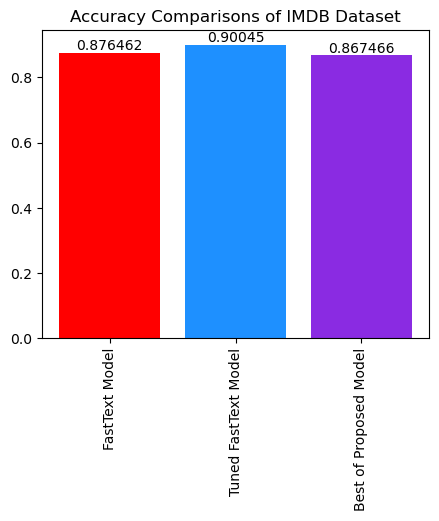

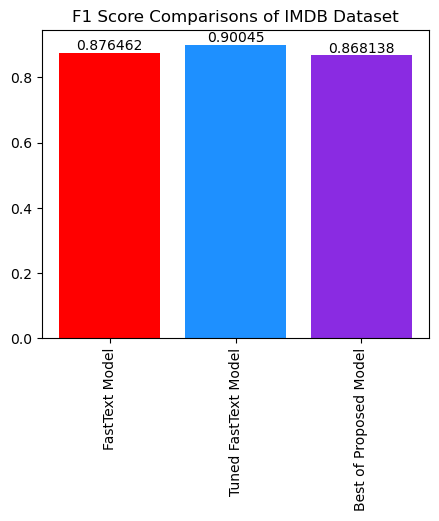

In [107]:
models = ["FastText Model", "Tuned FastText Model", "Best of Proposed Model"]
colors = ['r', 'dodgerblue', 'blueviolet']

best = imdb_accs1[np.argmax(imdb_accs1)]
imdb_accs.append(best)

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, imdb_accs, color=colors)
ax.bar_label(bars)
plt.title("Accuracy Comparisons of IMDB Dataset")
plt.xticks(rotation=90)
plt.show()

best = imdb_scores1[np.argmax(imdb_scores1)]
imdb_scores.append(best)

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, imdb_scores, color=colors)
ax.bar_label(bars)
plt.title("F1 Score Comparisons of IMDB Dataset")
plt.xticks(rotation=90)
plt.show()

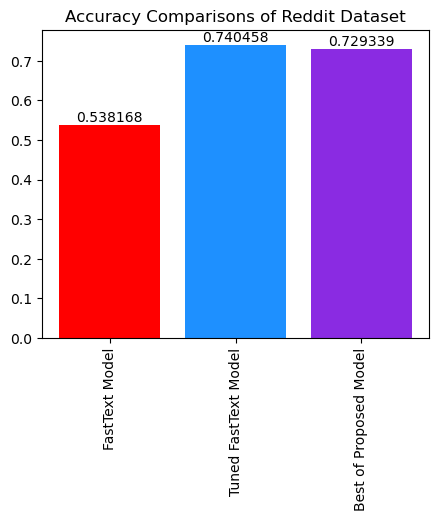

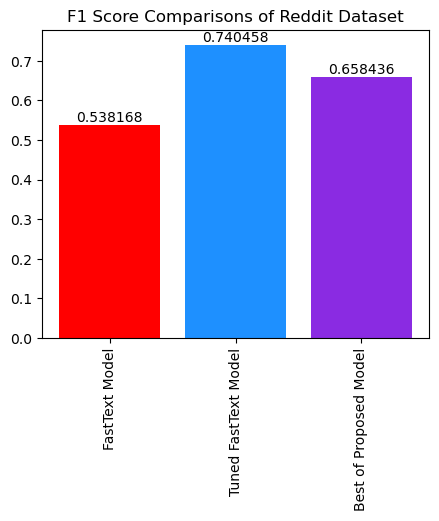

In [109]:
best = reddit_accs1[np.argmax(reddit_accs1)]
reddit_accs.append(best)

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, reddit_accs, color=colors)
ax.bar_label(bars)
plt.title("Accuracy Comparisons of Reddit Dataset")
plt.xticks(rotation=90)
plt.show()

best = reddit_scores1[np.argmax(reddit_scores1)]
reddit_scores.append(best)

fig, ax = plt.subplots(figsize=(5, 4))
bars = ax.bar(models, reddit_scores, color=colors)
ax.bar_label(bars)
plt.title("F1 Score Comparisons of Reddit Dataset")
plt.xticks(rotation=90)
plt.show()

Overall, The Model proposed in Bag of Tricks for Efficient Text Classification is much more effective than our proposed model, both in training time and in model accuracy (and F1 score). That being said, our model seems to perform better than FastText straight out of the box (no hyperparameter tuning) when it comes to a small dataset like in the Reddit set above. Moreover, our model produces more useful training byproducts that can be used as a basis for further research.